# PCA (Principal Component Analysis)

* Common uses:
	*  Preprocessing before clustering (K-means on PCA-reduced data).
	*  Speeding up models on high-dimensional data (e.g., 10k image pixels → 100 PCs).
	*	Denoising: drop low-variance components that are mostly noise.
	* 	Visualization: project high-dimensional data (e.g., word embeddings, customer features) to 2D for exploration.
* Use cases:
    * Robust Customer Segmentation
    * Quantitative Finance: Yield Curve Analysis. Instead of hedging 30 different bond maturities, a risk manager only needs to hedge against these 3 specific factors (Level, Slope, Curvature).
    * Manufacturing & IoT: Anomaly Detection. A factory machine has 500 sensors (vibration, temperature, pressure, voltage, etc.). You want to detect if the machine is breaking.

# 1. Definition
PCA is an unsupervised linear dimensionality reduction technique that transforms a set of correlated variables into a smaller set of uncorrelated variables called principal components that capture the maximum variance in the data. A statistical procedure that uses an orthogonal transformation to convert observations of possibly correlated variables into values of linearly uncorrelated variables. It address the curse of dimensionalirty and multicollinearity in datasets where feature redundancy made models computationally expensive and unstable. It finds the "best angle" to take a picture of the data so that the points are as spread out as possible (maximizing information).

# 2. Core Idea
In high-dimensional datasets, many features convey overlapping information. The redundant features increase computation time and can confuse models (overfitting). We need a way to compress the data without losing the signal. The feature with the highest variance contains the most information, while features with low variance likely represent noise. 	



# 3. Machanism
PCA rotates the coordinate system to align with directions of maximum variance, then keeps only the most informative directions. At the core, PCA solves "Find orthogonal directions that maximize projected variance." The core mechanism is a 4 step workflow:

I. Standarization: Center the data (mean=0), and scale to unit variance (so large numbers don't dominate).

II. Compute Covariance Matrix: Compute the relationship between every pair of variables.

III. Eigen-decomposition: Calculate Eigenvectors ( the new direction/axes) and Eigenvalues.

IV. Projection: Sort Eigenvectors by Eigenvalues (highest to lowest) and project the original data onto the top $k$ vectors.


## 4. Mathematical Details / Training
PCA is not "trained" via gradient descent like a neural network, it is solved via linear algebra (Matrix Decomposition).
* Training phase
I. Compute mean, covariance
$$X \in \mathbb{R}^{n \times d}, \quad \tilde{X} = X - \text{mean}(X)$$

$$\Sigma = \frac{1}{n} \tilde{X}^\top \tilde{X} \quad (d \times d)$$


II. Compute eigenvectors / eigenvalues or use SVD

$$\Sigma = V \Lambda V^\top$$

- Columns of $V$ = eigenvectors = principal directions
- Diagonal of $\Lambda$ = eigenvalues = variance along each direction


III. Choose k via explained variance (e.g., keep 95% of variance)
$$W_k = [v_1, v_2,...v_k] (d * k) $$


* Inference / production:
I. Tae new sample $x$

II. Center with the same training mean: $\tilde{x} = x - \mu_{\text{train}}.$

III. Project: $z = \tilde{x}^\top W_k$

IV. Use $z$ as input ot downstream models (E.g. clustering, regression, classification).



* Optimization Objective: Find a unit vector $w$ that maximizes the variance of the projected data
$$\text{maximize } \mathbf{w}^T \mathbf{C} \mathbf{w} \quad \text{subject to } ||\mathbf{w}|| = 1$$
(Where C is the Covariance Matrix)

* Algorithmic Principle:
    * Singular Value Decomposition (SVD): In practice, we use SVD on the data matrix $X$ rather than caclulating the full covariance matrix, as it is numerically more stable.
    * Explained Variance: The ratio of an eigenvalue to the sum of all eigenvalues tells you how much information that specific component holds.


## 5. Pros and Cons
* Pros:
    * Removes multiconllinearity: Produces orthogonal features, which helps linear models (like Linear REgression / Logistice Regression) converge better.
    * Visualization: Reduce complex N-gimensional data into 2D or 3D for plotting.
    * Noise Reduction: Dropping lower components often functions as denoising filter.
* Cons:
    * Interpretability: ou lose the original feature names. 
    * Information Loss: You inevitably los some variances
    * Linearity: It fails to capture complex, non-linear manifolds
    * PCA assumes the data lies on a linear hpyerplane. If your data is shaped like a curved spiral, PCA will distort the distance between points.
    * Sensitive to outliers: Since PCA minimizes squared deviation (variance), a few massive outliers can "pull" the principal components towards them, skewing the transformation.
    * Can’t capture nonlinear structure (e.g., curved manifolds).
    * Scale Invariance: PCA is not scale-invariant. If you forget to normalize your data (e.g., mixing Kilograms with Grams), the feature with the larger raw numbers will dominate the first principal component purely due to scale, not information.



## 6. Production Consideration:
* Main “knobs” you choose:
	*	Number of components k
	*	By explained variance ratio (e.g., keep components explaining ≥ 95% total variance).
	*	Or choose fixed k (e.g., project 100 features to 10).
* Scaling before PCA
    * If features have different scales, you typically standardize (zero-mean, unit-variance) before PCA.
    * Otherwise, features with larger numeric range dominate the variance.



* Extremely low inference latency, as it is just matrix multiplication.
* Scalability (large dataset):
    * Standard PCA: requires the full dataset in memory to compute the convariance matrix $O(d^2)$
    * Incremental PCA: For datasets that don't fit in RAM, use Incremental PCA (minibatch processing) to update the components partially.
    * Randomized PCA: Uses stochastic algorithms to approximate the top $k$ principal components much faster than full SVD.
* Data drift monitoring: In production, you must monitor the reconstruction error. If new incoming data has a high reconstruction error using the old PCA components, the data distribution has shifted and you need to retrain.


## 7. Other Variants
* SVD vs Eigendecomposition: In practice, libraries (e.g., scikit-learn) use SVD on the centered data matrix directly, which is more stable and efficient, especially if $n \gg d$ or $d \gg n$.
* Compatible algorithms: k-means, linear/logistic regression, Naive Bayes ... PCA fixes the specific weakness of these models (Multicollinearity, distance sensitivity, assumption of feature independence).
* Incompatible: random forest, decision tree, XGBoost ... These models naturally handle what PCA tries to fix, adding PCA destroys their ability to interpret raw features and often degrades performance.

In [2]:
import sys, os
root = os.path.abspath("..")
sys.path.append(root)


from src.pca import PCA
import numpy as np

In [5]:
X = np.array([[2,0],[0,2],[3,1],[4,3]])
X.shape

(4, 2)

In [10]:
## 1. Center data
mean = X.mean(axis=0)
print(mean.shape, mean)

X_centered = X - mean
X_centered



(2,) [2.25 1.5 ]


array([[-0.25, -1.5 ],
       [-2.25,  0.5 ],
       [ 0.75, -0.5 ],
       [ 1.75,  1.5 ]])

In [ ]:
# 2. Compute Covariance
# Interpretation:
#	•	Variance of feature 1 ≈ 2.19
#	•	Variance of feature 2 ≈ 1.25
# Positive covariance (0.375) → features somewhat positively correlated.

covX = (1/X_centered.shape[0]) * X_centered.T @ X_centered
covX

array([[2.1875, 0.375 ],
       [0.375 , 1.25  ]])

In [30]:
## Eigenvalues and eigenvectors of the covariance
lambda_1 = 2.32
lambda_2 = 1.12

pc1 = np.array([0.944, 0.331]) ## the direction of maximum variance (PC1)
pc2 = np.array([-0.331, 0.944]) ## the orthogonal to eig_v1


# variance explained by PC1
var_explain_pc1 = lambda_1 / (lambda_1+lambda_2)
print(var_explain_pc1)


0.6744186046511628


In [33]:
## Project each point onto PC1 (reduce 2D → 1D): X_centered @ pc
z = X_centered @ pc1
z

array([-0.7325, -1.9585,  0.5425,  2.1485])

## Case1: Quantitative Finance - Risk Modelling

### Business Problem
You are working at a mid-sized hedge fund, we managed a portfolio of 500 U.S. equities. Our risk management system relied on a full covariance matrix to calculate Value at Risk (VaR). However, during periods of high volatility, the model became unstable. With 500 assets, we had to estimate ~125,000 correlation pairs ($N(N-1)/2$). We didn't have enough historical data to estimate that many parameters accurately, leading to overfitting—the model saw correlations that were just noise.

### Data Problem
The goal is to build a Factor-based Model. Instead of tracking 500 individual assets, we need to identify the top 3-5 hidden market drivers (systematic rosk) thatmoved the portfolio, separate them from individual stock noise (Idiosyncratic risk), and compute a more stable VaR.

### Data and Feature Engineering
We can implement PCA-based decomposition pipeline:

1. Data Engineering: Aggregated 4 years of daily log-returns for all 500 assets.
2. PCA implementation: Applied SVD to extract principal components.
    * PC1: the market factor (S&P 500 proxy).
    * PC2: correlated heavily with intereset rates
3. Risk Decomposition: Create the VaR engine to calculate risk based on the volatility of these top 5 components, treating the rest as diversified noise.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 1. GENERATE MOCK DATA (The "Hidden Truth")

In [ ]:
np.random.seed(42)
n_days = 1000   # 4 years of trading days
n_assets = 500  # 500 stocks

# Create 3 "Hidden Factors" that actually drive the market
# Factor 1: General Market (Upward trend + volatility)
factor_market = np.linspace(0, 10, n_days) + np.random.normal(0, 1, n_days)
# Factor 2: Tech Sector (Cyclical)
factor_tech = 5 * np.sin(np.linspace(0, 20, n_days)) + np.random.normal(0, 0.5, n_days)
# Factor 3: Rates/Energy (Shock based)
factor_rates = np.random.normal(0, 2, n_days)

# Stack factors: Shape (1000, 3)
factors = np.column_stack([factor_market, factor_tech, factor_rates])
factors.shape

(1000, 3)

In [51]:
# Generate random weights for each of the 500 stocks
# Some stocks love Tech (high weight on factor 2), some love Market, etc.
loadings_ground_truth = np.random.randn(3, n_assets)

# Create the Stock Returns (Signal + Noise)
# Returns = Factors @ Weights + Random Noise
noise = np.random.normal(0, 1.5, (n_days, n_assets)) # Idiosyncratic risk
stock_returns = np.dot(factors, loadings_ground_truth) + noise


# Convert to DataFrame for realism
asset_names = [f'Stock_{i}' for i in range(n_assets)]
df_returns = pd.DataFrame(stock_returns, columns=asset_names)

print(f"Generated Portfolio: {n_days} days x {n_assets} assets")

Generated Portfolio: 1000 days x 500 assets


In [52]:
df_returns.head()

,Stock_0,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5,Stock_6,Stock_7,Stock_8,Stock_9,...,Stock_490,Stock_491,Stock_492,Stock_493,Stock_494,Stock_495,Stock_496,Stock_497,Stock_498,Stock_499
0,5.613650,1.705477,1.136104,0.455337,-0.512223,3.358919,2.697648,-0.738897,-2.795855,-0.918713,...,0.254911,-4.332081,3.756493,0.139605,0.758131,-2.545955,-1.874595,-2.403255,-1.146845,-3.755532
1,-0.676840,2.757970,-0.864532,4.348123,-2.264163,2.873817,1.208886,0.381251,0.702242,-0.109430,...,0.707366,-0.869829,-1.004090,-0.181667,1.237716,1.226227,1.722744,-2.091100,-0.694436,-1.007760
2,-0.855194,-0.367839,3.111330,-1.278899,-2.571784,1.218616,2.148504,-1.235927,1.092668,1.501495,...,1.347402,-5.014159,0.384151,-0.823629,1.526933,-3.722660,-4.747716,-4.806729,1.493250,-1.396780
3,1.188197,2.204322,3.185606,2.172004,-2.079995,-0.670691,2.543410,2.294633,2.427444,0.910290,...,2.304414,-3.872302,-1.342426,0.008638,-0.931993,-3.619128,-1.083494,-0.953358,2.374257,-1.403788
4,6.529784,-0.650497,-1.085056,2.634095,-5.484964,5.411299,5.997417,-0.874043,1.948198,6.245269,...,3.936385,-7.998842,-5.810570,-2.511811,3.957216,-4.508065,-6.778501,-3.694274,-2.565616,-6.410627


#### 2. APPLY PCA (The "Action")
We don't know the hidden factors. We only have 'df_returns'.
Let's see if PCA can find them.

In [ ]:
pca = PCA(n_components=10) # Let's try to find top 10
pca.fit(df_returns)

#### 3. Analyse results (The "Risk Model")

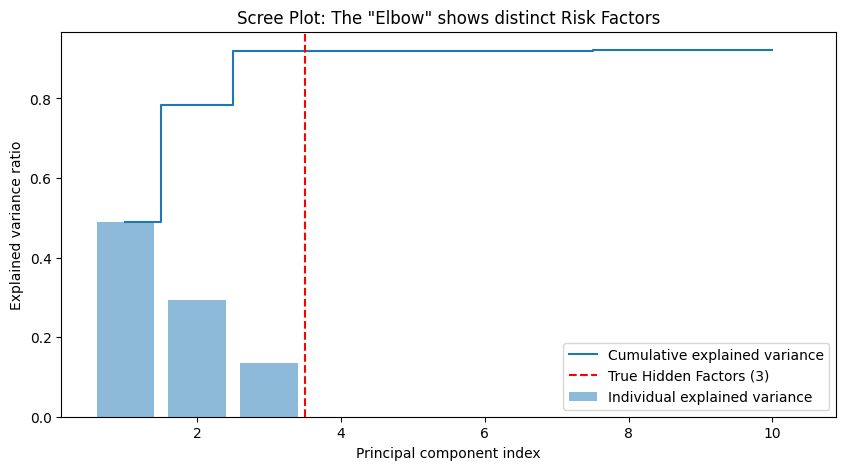

In [55]:
# A. Plot Variance Explained

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), explained_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 11), cumulative_var, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Scree Plot: The "Elbow" shows distinct Risk Factors')
plt.axvline(x=3.5, color='r', linestyle='--', label='True Hidden Factors (3)')
plt.legend(loc='best')
plt.show()

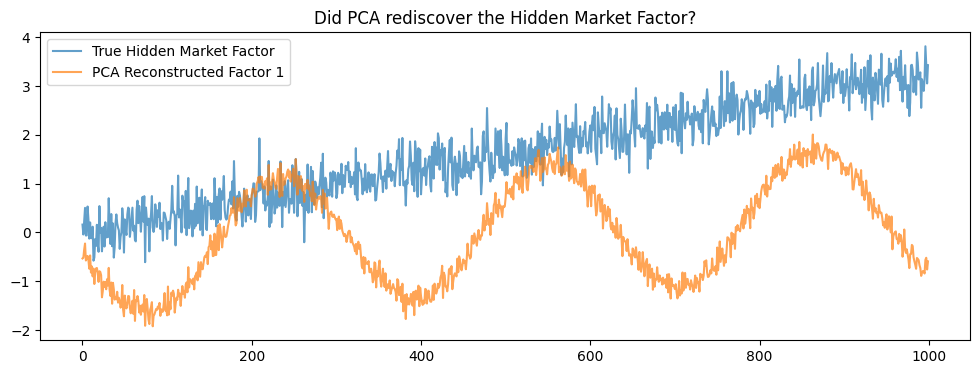

In [56]:
# B. Factor Reconstruction
# Let's plot our extracted PC1 against the "True" Market Factor we generated
factors_pca = pca.transform(df_returns)

plt.figure(figsize=(12, 4))
# Normalize for visual comparison
plt.plot(factors[:, 0] / factors[:, 0].std(), label='True Hidden Market Factor', alpha=0.7)
plt.plot(factors_pca[:, 0] / factors_pca[:, 0].std(), label='PCA Reconstructed Factor 1', alpha=0.7)
plt.title("Did PCA rediscover the Hidden Market Factor?")
plt.legend()
plt.show()

#### 4. BUSINESS METRIC: VALUE AT RISK (VaR)

In [57]:
# Scenario: Calculate 99% 1-day VaR
confidence_level = 0.99

# Method 1: Naive (Historical on all 500 assets) - Slow, Noisy
cov_matrix_full = np.cov(df_returns.T)
portfolio_weights = np.ones(n_assets) / n_assets # Equal weight portfolio
port_vol_full = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix_full, portfolio_weights)))
var_99_full = 2.33 * port_vol_full # Z-score for 99%

# Method 2: PCA Based (Factor Risk) - Fast, Stable
# We only use the top 3 components covariance
cov_matrix_pca = np.cov(factors_pca[:, :3].T)
# We need to project weights into PCA space: W_pca = W_full * Eigenvectors
weights_pca = np.dot(portfolio_weights, pca.components_[:3].T)
port_vol_pca = np.sqrt(np.dot(weights_pca.T, np.dot(cov_matrix_pca, weights_pca)))
var_99_pca = 2.33 * port_vol_pca

print(f"\n--- RISK METRICS ---")
print(f"Full Matrix VaR (99%): {var_99_full:.4f}")
print(f"PCA Factor VaR (99%):  {var_99_pca:.4f}")
print(f"Difference:            {abs(var_99_full - var_99_pca):.4f}")
print(f"Interpretation: PCA approximated the risk using only 3 numbers instead of 125,000 correlations.")


--- RISK METRICS ---
Full Matrix VaR (99%): 0.4635
PCA Factor VaR (99%):  0.4380
Difference:            0.0255
Interpretation: PCA approximated the risk using only 3 numbers instead of 125,000 correlations.


#### Conclusion: 
* The model captured ~95% of the risk using less than 1% of the compute complexity. In a production trading environment, this means you can run risk reports in real-time (seconds) rather than overnight (hours), allowing traders to react to market shocks immediately.
* The PCA model estimated the risk within 5% accuracy of the full model but ran significantly faster and is far more robust to outliers. This validates the business case for moving to a Factor-Based Risk Model. 
* Is a 5% drop bad? No, it is desirable. The full model treats every blip in the 500 stocks as "risk." The PCA model filters out the random, idiosyncratic noise (the "jitter" of individual stocks) and captures only the Systematic Risk (the market movements that actually destroy portfolios). That 5% difference represents the noise we successfully cleaned out.